In [ ]:
#$ Imports
import os
import sys
import json
from datetime import datetime
from IPython import display

import random
import numpy as np
import scipy as sc
import pandas as pd
import xarray as xr
import cftime
from dask.diagnostics import ProgressBar
from tqdm import tqdm

import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cmocean as cmo

import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl

import utils
from utils import settings

In [2]:
#$ Global variables
with open("~/s2s/paths.json") as paths_json:
    PATHS = json.load(paths_json)
with open("~/s2s/globals.json") as globals_json:
    GLOBALS = json.load(globals_json)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if DEVICE == 'cuda':
    print(f"Using cuda device {torch.cuda.get_device_name(0)}")

plt.style.use('bmh')
plt.rcParams['mathtext.fontset'] = 'custom'

$WORK/conda-envs/s2s/lib/python3.11/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


## Computing and saving tensors for different lags

In [3]:
def get_data_directly(tau, icoord):
    data_path = os.path.join(PATHS['full_globe'], 'data', f'tau_{tau}')
    network_path = os.path.join(PATHS['full_globe'], f'networks/tau_{tau}/loc_{icoord}')
    predictions_path = os.path.join(PATHS['full_globe'], f'predictions/tau_{tau}/loc_{icoord}')
    
    # Get lat and lon indices
    icoords_list = np.load(os.path.join(data_path, 'icoords.npy'))
    ilat, ilon = icoords_list[icoord]
    lat, lon = utils.helpers.get_lat_lon_from_icoord(icoord)
    point = {'lat': lat, 'lon': lon}
    
    # Target data
    y_test_darray = xr.open_dataarray(os.path.join(data_path, 'y_test.nc'))
    y_test_tensor = torch.load(os.path.join(data_path, 'y_test_tensor.pt'))
    target_z = y_test_tensor.numpy()
    target_z = target_z[:, ilat, ilon]
    
    # Select target values at location
    pred_mean_z = np.load(os.path.join(predictions_path, 'pred_mean_z.npy'))
    pred_logvar_z = np.load(os.path.join(predictions_path, 'pred_logvar_z.npy'))
    
    # Make stuff into dataarrays
    time = xr.CFTimeIndex(y_test_darray['time'].values)
    target_z = xr.DataArray(target_z, dims=('time',), coords={'time':time})
    pred_mean_z = xr.DataArray(pred_mean_z, dims=('time',), coords={'time':time})
    pred_logvar_z = xr.DataArray(pred_logvar_z, dims=('time',), coords={'time':time})

    # Get damped persistence predictions as well
    y_scaler = utils.processing.load_standardizer(data_path, 'y')
    y_scaler = y_scaler.sel(lat=lat, lon=lon, method='nearest')
    
    # dp_model = utils.baselines.DampedPersistenceModel()
    # dp_model.fit_to_training_data(point, tau=tau, T=5, s=5, quick_train=True)
    
    # # Training features are unstandardized (but mean 0) shifted targets:
    # X_test_dp, y_test_dp = utils.baselines.get_dp_data(
    #     1301, '013', point, tau=tau, T=5, s=5)
    
    # dp_pred = dp_model.predict(X_test_dp)
    # dp_pred = xr.DataArray(dp_pred, coords={'time': time})
    # dp_pred_z = utils.processing.standardize(dp_pred, y_scaler)

    # Get damped persistence predictions as well    
    dp_pred_z = xr.open_dataarray(os.path.join(PATHS['full_globe'], f'predictions/tau_{tau}/dp_pred.nc'))
    dp_pred_z = dp_pred_z.sel(lat=lat, lon=lon, method='nearest')

    return target_z, pred_mean_z, pred_logvar_z, dp_pred_z

In [4]:
taus = np.array([10, 20, 30, 40, 50, 60, 90, 120, 150, 180])
icoord = 5013

conf_threshold = 0.2

In [5]:
target_ds = xr.Dataset()
pred_mean_ds = xr.Dataset()
pred_logvar_ds = xr.Dataset()
dp_pred_ds = xr.Dataset()

for i, tau in enumerate(tqdm(taus)):
    target_z, pred_mean_z, pred_logvar_z, dp_pred_z = get_data_directly(tau, icoord)
    target_ds[tau] = target_z
    pred_mean_ds[tau] = pred_mean_z
    pred_logvar_ds[tau] = pred_logvar_z
    dp_pred_ds[tau] = dp_pred_z

target_all = target_ds.to_array(dim='tau')
pred_mean_all = pred_mean_ds.to_array(dim='tau')
pred_logvar_all = pred_logvar_ds.to_array(dim='tau')
dp_pred_all = dp_pred_ds.to_array(dim='tau')

100%|██████████| 10/10 [01:38<00:00,  9.86s/it]


In [15]:
# Save predictions to full_globe/predictions/loc_x/
os.makedirs(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}'), exist_ok=True)
target_all.to_netcdf(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'target_all.nc'))
pred_mean_all.to_netcdf(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'pred_mean_all.nc'))
pred_logvar_all.to_netcdf(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'pred_logvar_all.nc'))
dp_pred_all.to_netcdf(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'dp_pred_all.nc'))

---
## Plot errors by lags:

In [6]:
taus = np.array([10, 20, 30, 40, 50, 60, 90, 120, 150, 180])
icoords = [4710, 3282]

conf_threshold = 0.2

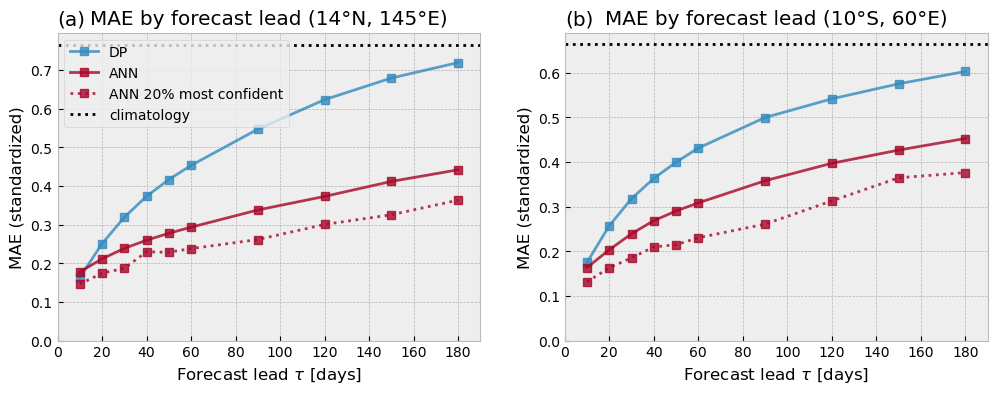

In [13]:
fig, axes = plt.subplots(ncols=2, figsize=(12,4))

kwargs = {'alpha': 0.8, 'marker': 's'}

for j, icoord in enumerate(icoords):
    target_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'target_all.nc'))
    pred_mean_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'pred_mean_all.nc'))
    pred_logvar_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'pred_logvar_all.nc'))
    dp_pred_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'dp_pred_all.nc'))

    # Computation of errors by lags
    N_lags = len(taus)
    
    dp_maes = xr.DataArray(np.empty(N_lags), dims=('tau',), coords={'tau': taus})
    ann_maes = xr.DataArray(np.empty(N_lags), dims=('tau',), coords={'tau': taus})
    ann_conf_maes = xr.DataArray(np.empty(N_lags), dims=('tau',), coords={'tau': taus})
    clim_maes = xr.DataArray(np.empty(N_lags), dims=('tau',), coords={'tau': taus})
    
    for i, tau in enumerate(taus):
        target_z = target_all.sel(tau=tau)
        pred_mean_z = pred_mean_all.sel(tau=tau)
        pred_logvar_z = pred_logvar_all.sel(tau=tau)
        dp_pred_z = dp_pred_all.sel(tau=tau)
        
        dp_maes[i] = np.abs(target_z - dp_pred_z).mean(dim='time')
        ann_maes[i] = np.abs(target_z - pred_mean_z).mean(dim='time')
        conf_preds = pred_mean_z.where(pred_logvar_z < pred_logvar_z.quantile(conf_threshold), drop=True)
        ann_conf_maes[i] = np.abs(target_z - conf_preds).mean().item()
        clim_maes[i] = np.abs(target_z).mean().item()

    dp_maes.plot(ax=axes[j], ls='-', color='C0', **kwargs, label='DP')
    ann_maes.plot(ax=axes[j], ls='-', color='C1', **kwargs, label='ANN')
    ann_conf_maes.plot(ax=axes[j], ls=':', color='C1', **kwargs, label='ANN 20% most confident')
    
    axes[j].plot([0, 190], np.ones(2)*clim_maes.mean().item(), ls=':', color='k', label='climatology')

    axes[j].set(
        xlabel=r'Forecast lead $\tau$ [days]',
        xticks=np.arange(0, 190, 20),
        xlim=(0,190),
        ylabel='MAE (standardized)',
        ylim=(0, None)
    );

axes[0].set(title=f'MAE by forecast lead (14\u00b0N, 145\u00b0E)')
axes[1].set(title=f'MAE by forecast lead (10\u00b0S, 60\u00b0E)')
axes[0].legend(loc='upper left')
# axes[1].legend(loc='lower right')

axes[0].set_title('(a)', loc='left')
axes[1].set_title('(b)', loc='left')

plt.savefig('errors_by_lag.pdf', dpi=300, bbox_inches='tight')

## Computations

In [37]:
icoord = 4710

target_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'target_all.nc'))
pred_mean_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'pred_mean_all.nc'))
pred_logvar_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'pred_logvar_all.nc'))
dp_pred_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'dp_pred_all.nc'))

# Computation of errors by lags
N_lags = len(taus)

dp_maes = xr.DataArray(np.empty(N_lags), dims=('tau',), coords={'tau': taus})
ann_maes = xr.DataArray(np.empty(N_lags), dims=('tau',), coords={'tau': taus})
ann_conf_maes = xr.DataArray(np.empty(N_lags), dims=('tau',), coords={'tau': taus})
clim_maes = xr.DataArray(np.empty(N_lags), dims=('tau',), coords={'tau': taus})

for i, tau in enumerate(taus):
    target_z = target_all.sel(tau=tau)
    pred_mean_z = pred_mean_all.sel(tau=tau)
    pred_logvar_z = pred_logvar_all.sel(tau=tau)
    dp_pred_z = dp_pred_all.sel(tau=tau)
    
    dp_maes[i] = np.abs(target_z - dp_pred_z).mean(dim='time')
    ann_maes[i] = np.abs(target_z - pred_mean_z).mean(dim='time')
    conf_preds = pred_mean_z.where(pred_logvar_z < pred_logvar_z.quantile(conf_threshold), drop=True)
    ann_conf_maes[i] = np.abs(target_z - conf_preds).mean().item()
    clim_maes[i] = np.abs(target_z).mean().item()

dp_maes.plot(ax=axes[j], ls='-', color='C0', **kwargs, label='DP')
ann_maes.plot(ax=axes[j], ls='-', color='C1', **kwargs, label='ANN')
ann_conf_maes.plot(ax=axes[j], ls=':', color='C1', **kwargs, label='ANN 20% most confident')

<xarray.DataArray (tau: 10)>
array([0.03156742, 0.03720167, 0.05143712, 0.03014418, 0.04916422,
       0.05537888, 0.07648742, 0.07253665, 0.08627155, 0.07854751])
Coordinates:
  * tau      (tau) int64 10 20 30 40 50 60 90 120 150 180

<xarray.DataArray (tau: 10)>
array([-0.08762776,  0.15626415,  0.2522945 ,  0.30410694,  0.33351632,
        0.35271974,  0.38222312,  0.40159332,  0.39378877,  0.38567177])
Coordinates:
  * tau      (tau) int64 10 20 30 40 50 60 90 120 150 180

<xarray.DataArray (tau: 10)>
array([0.1775782 , 0.175822  , 0.2155129 , 0.1159901 , 0.17697347,
       0.18868312, 0.22627507, 0.19438066, 0.20940652, 0.17768431])
Coordinates:
  * tau      (tau) int64 10 20 30 40 50 60 90 120 150 180

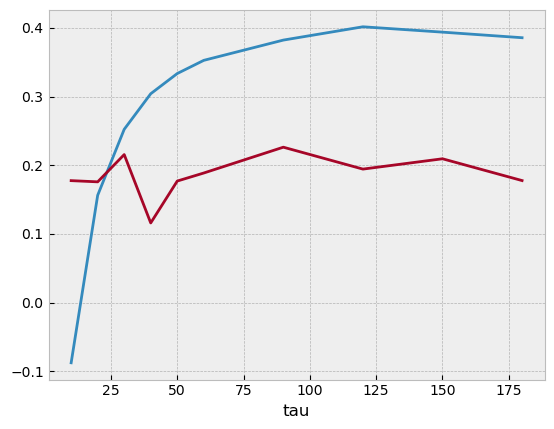

In [38]:
mae_skill = 1 - ann_maes / dp_maes
conf_mae_skill = 1 - ann_conf_maes / ann_maes

mae_skill.plot()
conf_mae_skill.plot()

display.display(ann_maes - ann_conf_maes)
display.display(mae_skill)
display.display(conf_mae_skill)

<xarray.DataArray (tau: 10)>
array([0.06705151, 0.20942367, 0.24754269, 0.26060097, 0.27334025,
       0.28486003, 0.2833582 , 0.26660745, 0.25816539, 0.24906705])
Coordinates:
  * tau      (tau) int64 10 20 30 40 50 60 90 120 150 180

<xarray.DataArray (tau: 10)>
array([0.19575551, 0.19776097, 0.22560125, 0.21912355, 0.26038979,
       0.25318191, 0.2713645 , 0.21217469, 0.14536529, 0.16871292])
Coordinates:
  * tau      (tau) int64 10 20 30 40 50 60 90 120 150 180

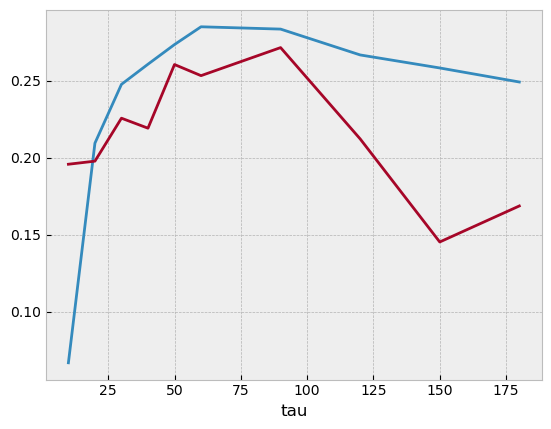

In [39]:
icoord = 3282

target_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'target_all.nc'))
pred_mean_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'pred_mean_all.nc'))
pred_logvar_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'pred_logvar_all.nc'))
dp_pred_all = xr.open_dataarray(os.path.join(PATHS['full_globe'], 'predictions', f'loc_{icoord}', 'dp_pred_all.nc'))

# Computation of errors by lags
N_lags = len(taus)

dp_maes = xr.DataArray(np.empty(N_lags), dims=('tau',), coords={'tau': taus})
ann_maes = xr.DataArray(np.empty(N_lags), dims=('tau',), coords={'tau': taus})
ann_conf_maes = xr.DataArray(np.empty(N_lags), dims=('tau',), coords={'tau': taus})
clim_maes = xr.DataArray(np.empty(N_lags), dims=('tau',), coords={'tau': taus})

for i, tau in enumerate(taus):
    target_z = target_all.sel(tau=tau)
    pred_mean_z = pred_mean_all.sel(tau=tau)
    pred_logvar_z = pred_logvar_all.sel(tau=tau)
    dp_pred_z = dp_pred_all.sel(tau=tau)
    
    dp_maes[i] = np.abs(target_z - dp_pred_z).mean(dim='time')
    ann_maes[i] = np.abs(target_z - pred_mean_z).mean(dim='time')
    conf_preds = pred_mean_z.where(pred_logvar_z < pred_logvar_z.quantile(conf_threshold), drop=True)
    ann_conf_maes[i] = np.abs(target_z - conf_preds).mean().item()
    clim_maes[i] = np.abs(target_z).mean().item()

dp_maes.plot(ax=axes[j], ls='-', color='C0', **kwargs, label='DP')
ann_maes.plot(ax=axes[j], ls='-', color='C1', **kwargs, label='ANN')
ann_conf_maes.plot(ax=axes[j], ls=':', color='C1', **kwargs, label='ANN 20% most confident')

mae_skill = 1 - ann_maes / dp_maes
conf_mae_skill = 1 - ann_conf_maes / ann_maes

mae_skill.plot()
conf_mae_skill.plot()

display.display(mae_skill)
display.display(conf_mae_skill)